In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
import os,glob
from PIL import Image

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

np.random.seed(3)

In [ ]:
# 이미지를 numpy 배열로 만들기
directory = 'C:/Users/dltmd/jupyterSave/img'
categories = ["0","1","2"]
nb_classes = len(categories)

w = 300 
h = 300
pixels = w*h*3

X = []
y = []

for idx, obj in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = directory + "/" + obj
    files = glob.glob(image_dir+"/*.jpg")
    print(obj, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((w, h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 10000 == 0:
            print(obj, " : ", f)

In [ ]:
# numpy 배열을 train, test, val로 나누어 npy파일로 저장
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
xy = (X_train, X_test, y_train, y_test, X_val, y_val)
np.save("C:/Users/dltmd/jupyterSave/multi_image_data.npy", xy)

In [3]:
#이미지 데이터 불러오기
X_train, X_test, y_train, y_test, X_val, y_val = np.load("C:/Users/dltmd/jupyterSave/multi_image_data.npy")

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [ ]:
#모델 구축
model = Sequential()
model.add(Input(shape=(300,300,3), name='input_layer'))
model.add(preprocessing.Rescaling(1./255))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv_layer1')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(rate=0.5))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv_layer2')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(rate=0.5)) 

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv_layer3')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(rate=0.5)) 
model.add(Flatten())

model.add(Dense(256, activation='relu', name='hidden_layer1')) 
model.add(Dropout(rate=0.5)) 
model.add(Dense(128, activation='relu', name='hidden_layer2')) 
model.add(Dropout(rate=0.5)) 
model.add(Dense(3, activation='softmax', name='output_layer'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#모델 학습
early_stopping = EarlyStopping(patience = 5) # 조기종료 콜백함수 정의

history = model.fit(
        X_train, y_train, validation_data=(X_val, y_val), batch_size=100, epochs=30,
        callbacks=[early_stopping])

In [9]:
# 학습 곡선을 나타내는 함수
def plot_loss_curve(history):
    plt.figure(figsize=(15, 10))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train loss=", history.history['loss'][-1])
    print("validation loss=", history.history['val_loss'][-1])
    
def plot_acc_curve(history):
    plt.figure(figsize=(15, 10))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()   
    
    print("train accuracy=", history.history['accuracy'][-1])
    print("validation accuracy=", history.history['val_accuracy'][-1])

In [ ]:
plot_loss_curve(history)
plot_acc_curve(history)

model.save('cnn07')

In [7]:
model = load_model("model-201511158")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 300, 300, 3)       0         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 32)      0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 64)        0

In [4]:
from sklearn.metrics import classification_report

#y_pred와 y_test를 일차원 배열로 만드는 함수
def y_to_list(y_pred, y_test):
    yp = []
    yt = []
    for i in y_pred:
        idx = 0
        m = 0
        for j in range(0,3):
            if(i[j]>m):
                m = i[j]
                idx = j
        yp.append(idx)
    
    for i in y_test:
        idx = 0
        for j in range(0,3):
            if(i[j]==1):
                idx = j
                break
        yt.append(idx)
    
    return yp, yt

import random

#실제값과 예측 값을 비교하는 함수
def acVSpred(X_test ,y_test, y_pred):
    n = random.randrange(0, 4500)
    plt.imshow(X_test[n])
    print("acutal value : "+ str(y_test[n]))
    print("predict value : "+ str(y_pred[n]))

In [5]:
# 모델 평가
print("-- Evaluate --")
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
141/141 [==============================] - 74s 519ms/step - loss: 0.7752 - accuracy: 0.8033
accuracy: 80.33%


In [8]:
#모델 예측 및 classification_report를 통한 평가
y_pred = model.predict(X_test)

yp, yt = y_to_list(y_pred, y_test)

target_names = ['food', 'interior', 'exterior']
print(classification_report(yt, yp, target_names=target_names))

              precision    recall  f1-score   support

        food       0.92      0.87      0.90      2027
    interior       0.76      0.68      0.72      1423
    exterior       0.67      0.83      0.74      1050

    accuracy                           0.80      4500
   macro avg       0.78      0.80      0.79      4500
weighted avg       0.81      0.80      0.80      4500



acutal value : 1
predict value : 1


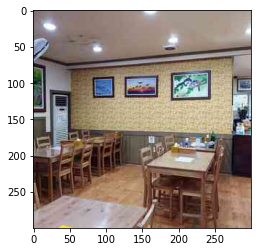

In [6]:
acVSpred(X_test, yt, yp)